In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle

import ROOT

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Welcome to JupyROOT 6.28/06


In [2]:
print("Loading sample into memory...")
with uproot.open("dataset_mu60_H1A3_10k_true_EMfrac.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    #jet_corrJVF = f["jet_corrJVF"].array()
    #jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    
    #trk_pt = f["trk_jet_pT"].array()
    #trk_eta = f["trk_jet_eta"].array()
    #trk_phi = f["trk_jet_phi"].array()
    #trk_q = f["trk_jet_q"].array()
    #trk_d0 = f["trk_jet_d0"].array()
    #trk_z0 = f["trk_jet_z0"].array()
    #trk_label = f["trk_jet_label"].array()
    
    trk_pt = f["trk_pT"].array()
    trk_eta = f["trk_eta"].array()
    trk_phi = f["trk_phi"].array()
    trk_q = f["trk_q"].array()
    trk_d0 = f["trk_d0"].array()
    trk_z0 = f["trk_z0"].array()
    trk_label = f["trk_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()
    
    event_no = ak.zeros_like(jet_pt).to_list()
    jet_no = ak.zeros_like(jet_pt).to_list()

Loading sample into memory...


In [3]:
for event in range(len(jet_pt)):
    for jet in range(len(jet_pt[event])):
        event_no[event][jet] = event
        jet_no[event][jet] = jet
        
event_no = ak.Array(event_no)
jet_no = ak.Array(jet_no)

In [4]:
print("Joining jet features...")
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,event_no,jet_no]
jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)
print("\tNum Events: ", len(jet_feats))
print("\tNum Jets in first event: ", len(jet_feats[0]))
print("\tNum Jet Features: ", len(jet_feats[0][0]))

#print("Joining track features...")
#trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_label]
#trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
#trk_feats = ak.concatenate(trk_feat_list, axis=3)
#print("\tNum Events: ", len(trk_feats))
#print("\tNum Jets in first event: ", len(trk_feats[0]))
#print("\tNum Tracks in first event first jet: ", len(trk_feats[0][0]))
#print("\tNum Tracks features: ", len(trk_feats[0][0][0]))

Joining jet features...
	Num Events:  10000
	Num Jets in first event:  20
	Num Jet Features:  6


In [5]:
%%time
num_events = len(jet_pt)
trk_feats = []
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    idx_list = list(jet_trk_IDX[event])
    idx_list.append(len(trk_pt[event]))
    
    jet_trk_feats = []
    for i in range(len(idx_list)-1):
        start_idx = idx_list[i]
        end_idx = idx_list[i+1]
        trk_pt_tmp = np.array(trk_pt[event][start_idx:end_idx])
        trk_eta_tmp = np.array(trk_eta[event][start_idx:end_idx])
        trk_phi_tmp = np.array(trk_phi[event][start_idx:end_idx])
        trk_q_tmp = np.array(trk_q[event][start_idx:end_idx])
        trk_d0_tmp = np.array(trk_d0[event][start_idx:end_idx])
        trk_z0_tmp = np.array(trk_z0[event][start_idx:end_idx])
        trk_label_tmp = np.array(trk_label[event][start_idx:end_idx])

        feats = [trk_pt_tmp, trk_eta_tmp, trk_phi_tmp, trk_q_tmp,
                trk_d0_tmp, trk_z0_tmp, trk_label_tmp]
        feats = np.stack(feats, axis=-1)
        jet_trk_feats.append(feats)
    
    trk_feats.append(jet_trk_feats)
    
trk_feats = ak.Array(trk_feats)

print("Processing: ", num_events, " / ", num_events)
print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Processing:  10000  /  10000
Num Events:  10000
Num Jets in first event:  20
Num Tracks in first event first jet:  72
Num Tracks features:  7
CPU times: user 4min 4s, sys: 2.08 s, total: 4min 6s
Wall time: 4min 5s


In [6]:
print("Applying Cuts...")
# Apply Jet cuts
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

# Apply Track cuts
trk_q_cut = selected_tracks[:,:,:,3]!=0            # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4.5    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4          # 400MeV Cut
mask = trk_q_cut & trk_eta_cut & trk_pt_cut
selected_tracks = selected_tracks[mask]

# Skip trackless jets!
trackless_jets_mask = (ak.num(selected_tracks, axis=2)!=0)
selected_jets = selected_jets[trackless_jets_mask]
selected_tracks = selected_tracks[trackless_jets_mask]

Applying Cuts...


Normalizing Jet Features...


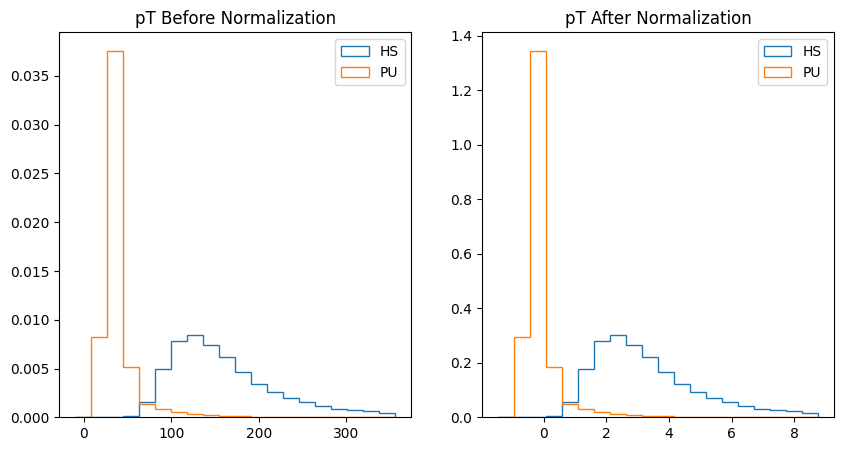

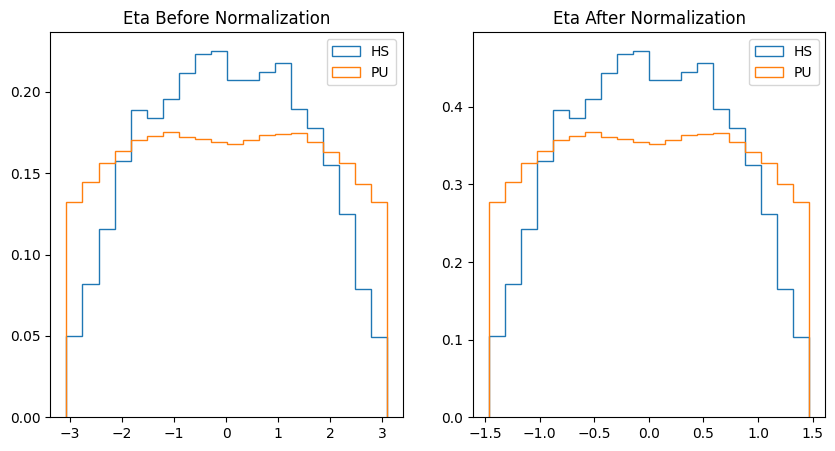

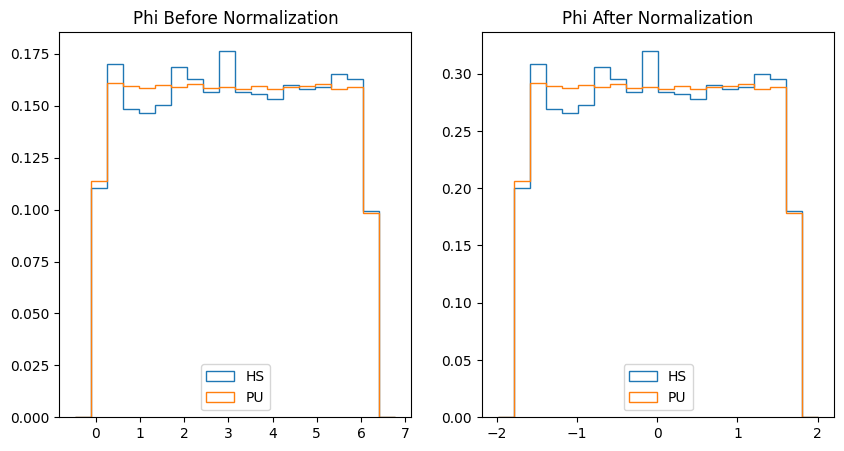

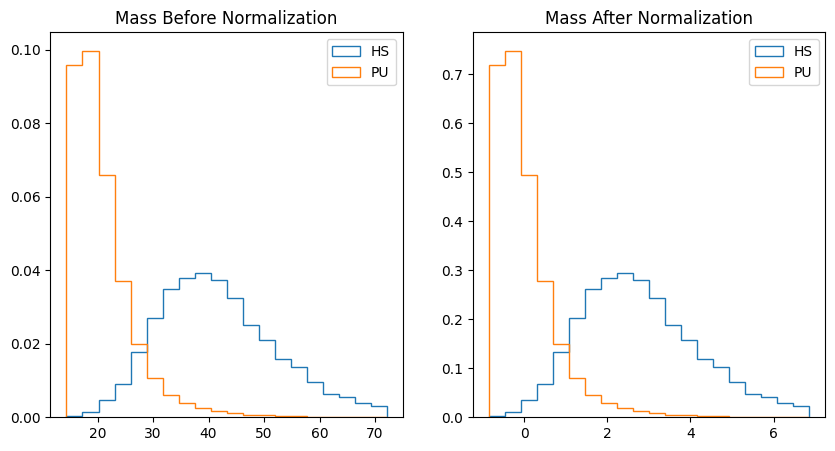

Normalizing Track Features...


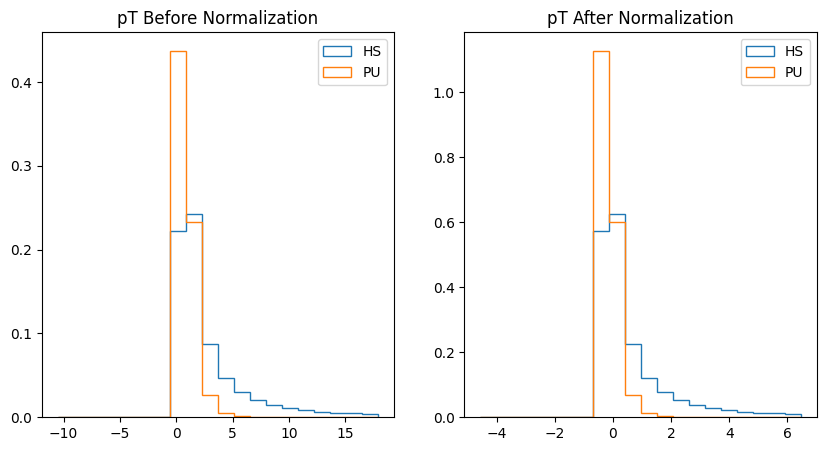

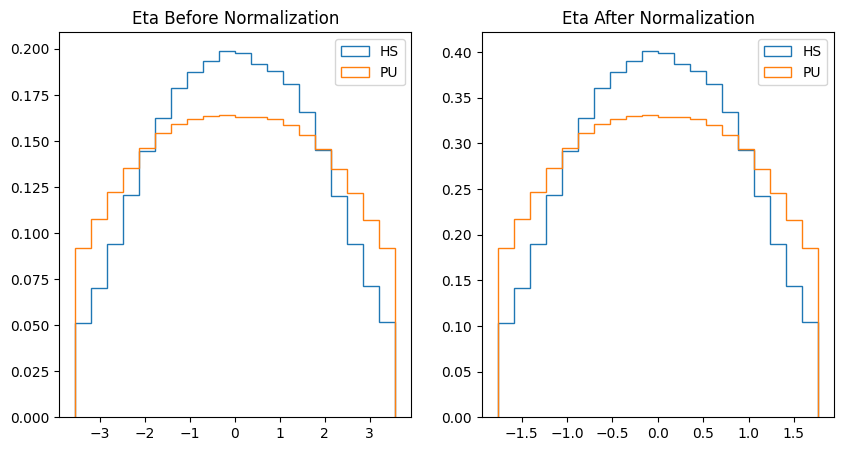

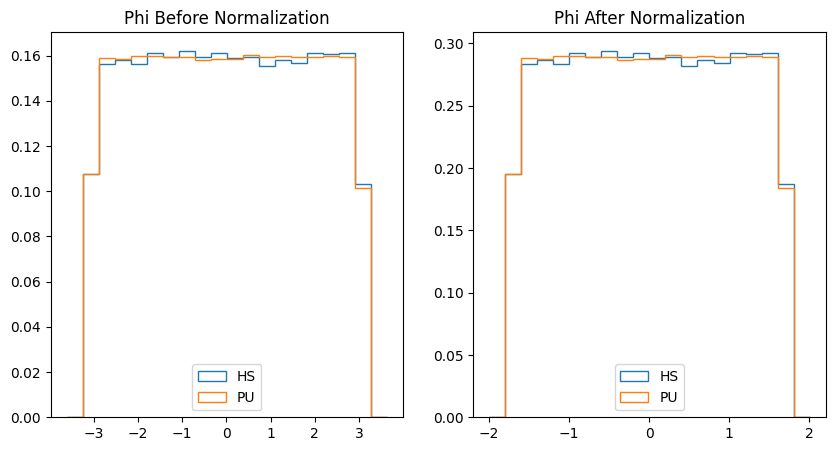

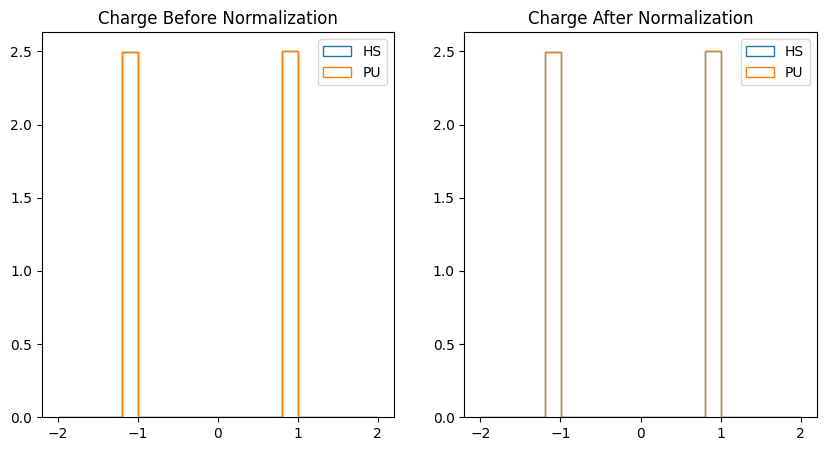

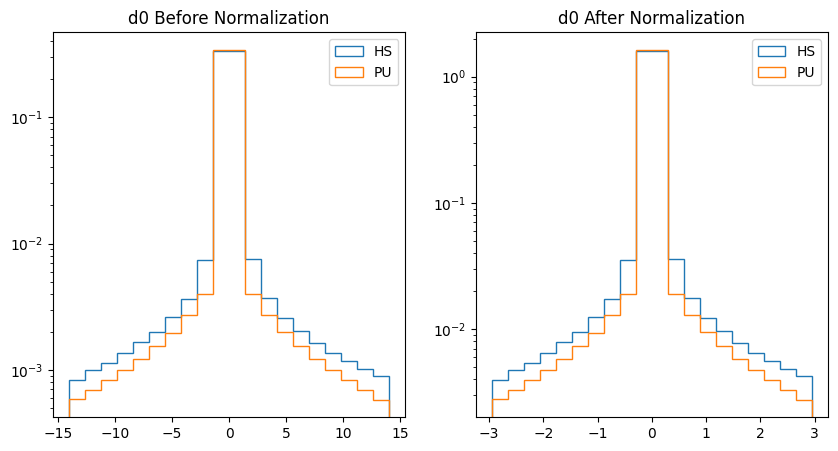

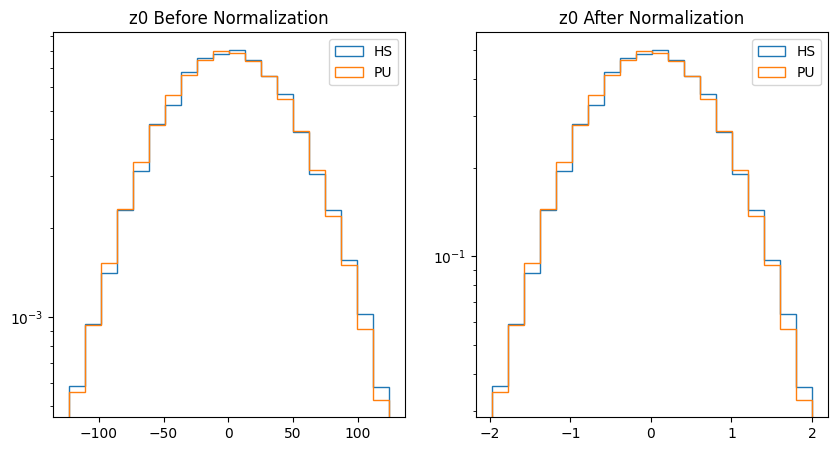

In [7]:
print("Normalizing Jet Features...")
num_jet_feats = len(selected_jets[0][0])-2

sig = selected_jets[:,:,-1]<0.7
bkg = ~sig

var_list = ['pT','Eta','Phi','Mass']

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    #plt.savefig("plots/preprocessing/Normalized_Jet_"+var_list[i]+".png")
    plt.show()
    #print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    #print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))   
    
# Append Labels
norm_list.append(selected_jets[:,:,-2])
norm_list.append(selected_jets[:,:,-1])
Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

print("Normalizing Track Features...")
num_trk_feats = len(selected_tracks[0][0][0])-1

sig = selected_tracks[:,:,:,-1]==-1
bkg = ~sig

var_list = ['pT','Eta','Phi','Charge', 'd0', 'z0']

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    if '0' in var_list[i]:
        ax1.set_yscale('log')
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    if '0' in var_list[i]:
        ax2.set_yscale('log')
    #plt.savefig("plots/preprocessing/Normalized_Track_"+var_list[i]+".png")
    plt.show()
    #print("Mean Before: ", mean, "\nMean After: ", ak.mean(norm))
    #print("STD Before: ", std, "\nSTD After: ", ak.std(norm))
    
# Add label
norm_list.append(selected_tracks[:,:,:,-1])
    
# Combine features
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [8]:
print("Padding Tracks to common length...")
all_tracks = ak.flatten(selected_tracks, axis=2)
num_events = len(selected_jets)
Event_Data = []
Event_Labels = []
for event in range(num_events):
    if event%1==0:
        print("\tProcessing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])        
        pad = (0,0,0,max_num_trks-len(tracks))        
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    # Append all data but don't include label 0:-1!
    flat_tracks = torch.Tensor(all_tracks[event][:,0:-1])
    Event_Data.append((jets[:,0:4],tracks[:,:,0:-1],flat_tracks))
    Event_Labels.append((jets[:,-2],jets[:,-1]))
print("\tProcessing: ", num_events, " / ", num_events)

Padding Tracks to common length...
	Processing:  10000  /  10000


In [9]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 8
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
        
        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))
        
        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)
        
        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)
        
        # Get output
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [10]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [12]:
PUfracNN = torch.load("./results/PUFNN_diHiggs_50k.torch").to(device)
EfracNN = torch.load("./results/EfracNN_diHiggs_20k.torch").to(device)
MfracNN = torch.load("./results/MfracNN_diHiggs_20k.torch").to(device)

/tmp/ipykernel_3992594/898438776.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PUfracNN = torch.load("./results/PUFNN_diHiggs_50k.torch").to(device)
/tmp/ipykernel_399

In [13]:
PUfrac = ak.ones_like(jet_pt) * -1
PUfrac = PUfrac.to_list()

Efrac = ak.ones_like(jet_pt) * -1
Efrac = Efrac.to_list()

Mfrac = ak.ones_like(jet_pt) * -1
Mfrac = Mfrac.to_list()

In [14]:
for event in range(len(Event_Data)):
    jets = Event_Data[event][0][:,0:4]
    jet_trks = Event_Data[event][1]
    trks = Event_Data[event][2]
    
    PUfr_pred = PUfracNN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu().numpy()
    Efr_pred = EfracNN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu().numpy()
    Mfr_pred = MfracNN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu().numpy()

    
    for jet in range(len(Event_Data[event][0])):
        event_No = int(Event_Labels[event][0][jet].detach().numpy())
        jet_No = int(Event_Labels[event][1][jet].detach().numpy())

        PUfrac[event_No][jet_No] = float(PUfr_pred[jet][0])
        Mfrac[event_No][jet_No] = float(Efr_pred[jet][0])
        Efrac[event_No][jet_No] = float(Mfr_pred[jet][0])

In [15]:
df = ak.to_rdataframe({"PUfrac": PUfrac,"Efrac": Efrac,"Mfrac": Mfrac})

In [16]:
df.Snapshot("jet_scores", "jet_scores.root", ("PUfrac","Efrac","Mfrac"))

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x64aa279d1f30>